# 动量法
使用梯度下降法，每次都会朝着目标函数下降最快的方向，这也称为最速下降法。这种更新方法看似非常快，实际上存在一些问题。

## 梯度下降法的问题
考虑一个二维输入，$[x_1, x_2]$，输出的损失函数 $L: R^2 \rightarrow R$，下面是这个函数的等高线

![](https://ws1.sinaimg.cn/large/006tKfTcly1fmnketw5f4j30az04lq31.jpg)

可以想象成一个很扁的漏斗，这样在竖直方向上，梯度就非常大，在水平方向上，梯度就相对较小，所以我们在设置学习率的时候就不能设置太大，为了防止竖直方向上参数更新太过了，这样一个较小的学习率又导致了水平方向上参数在更新的时候太过于缓慢，所以就导致最终收敛起来非常慢。

## 动量法
动量法的提出就是为了应对这个问题，我们梯度下降法做一个修改如下

$$
v_i = \gamma v_{i-1} + \eta \nabla L(\theta)
$$
$$
\theta_i = \theta_{i-1} - v_i
$$

其中 $v_i$ 是当前速度，$\gamma$ 是动量参数，是一个小于 1的正数，$\eta$ 是学习率

相当于每次在进行参数更新的时候，都会将之前的速度考虑进来，每个参数在各方向上的移动幅度不仅取决于当前的梯度，还取决于过去各个梯度在各个方向上是否一致，如果一个梯度一直沿着当前方向进行更新，那么每次更新的幅度就越来越大，如果一个梯度在一个方向上不断变化，那么其更新幅度就会被衰减，这样我们就可以使用一个较大的学习率，使得收敛更快，同时梯度比较大的方向就会因为动量的关系每次更新的幅度减少，如下图

![](https://ws1.sinaimg.cn/large/006tNc79gy1fmo5l53o76j30ak04gjrh.jpg)

比如我们的梯度每次都等于 g，而且方向都相同，那么动量法在该方向上使参数加速移动，有下面的公式：

$$
v_0 = 0
$$
$$
v_1 = \gamma v_0 + \eta g = \eta g
$$
$$
v_2 = \gamma v_1 + \eta g = (1 + \gamma) \eta g
$$
$$
v_3 = \gamma v_2 + \eta g = (1 + \gamma + \gamma^2) \eta g
$$
$$
\cdots
$$
$$
v_{+ \infty} = (1 + \gamma + \gamma^2 + \gamma^3 + \cdots) \eta g = \frac{1}{1 - \gamma} \eta g
$$

如果我们把 $\gamma$ 定为 0.9，那么更新幅度的峰值就是原本梯度乘学习率的 10 倍。

本质上说，动量法就仿佛我们从高坡上推一个球，小球在向下滚动的过程中积累了动量，在途中也会变得越来越快，最后会达到一个峰值，对应于我们的算法中就是，动量项会沿着梯度指向方向相同的方向不断增大，对于梯度方向改变的方向逐渐减小，得到了更快的收敛速度以及更小的震荡。

下面我们手动实现一个动量法，公式已经在上面了

In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np
import time
import tensorflow.examples.tutorials.mnist.input_data as input_data

import sys
sys.path.append('..')

tf.set_random_seed(2017)

In [2]:
# 神经网络构建
def hidden_layer(layer_input, output_depth, scope='hidden_layer', reuse=None):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse=reuse):
        # 注意这里的初始化方法是truncated_normal
        w = tf.get_variable(initializer=tf.truncated_normal_initializer(stddev=0.1), shape=(input_depth, output_depth), name='weights')
        # 注意这里用 0.1 对偏置进行初始化
        b = tf.get_variable(initializer=tf.constant_initializer(0.1), shape=(output_depth), name='bias')
        net = tf.matmul(layer_input, w) + b
        
        return net

def DNN(x, output_depths, scope='DNN', reuse=None):
    net = x
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope='layer%d' % i, reuse=reuse)
        # 注意这里的激活函数
        net = tf.nn.relu(net)
    # 数字分为0, 1, ..., 9 所以这是10分类问题
    # 对应于 one_hot 的标签, 所以这里输出一个 10维 的向量
    net = hidden_layer(net, 10, scope='classification', reuse=reuse)
    
    return net

In [3]:
# 数据导入
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

train_set = mnist.train
test_set = mnist.test

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# 定义模型
input_ph = tf.placeholder(shape=(None, 784), dtype=tf.float32)
label_ph = tf.placeholder(shape=(None, 10), dtype=tf.int64)

# dnn = DNN(input_ph, [200], weights_collection='params', biases_collection='params')
dnn = DNN(input_ph, [200])

In [5]:
# 构建`loss`和`acc`
loss = tf.losses.softmax_cross_entropy(logits=dnn, onehot_labels=label_ph)

acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn, axis=-1), tf.argmax(label_ph, axis=-1)), dtype=tf.float32))

In [6]:
sess = tf.InteractiveSession()

### 开始训练

我们来看看结果

### tf.train.MomentumOptimizer
`tensorflow`中也集成了`momentum`方法

In [7]:
train_op = tf.train.MomentumOptimizer(0.01, 0.9).minimize(loss)

In [8]:
batch_size = 64

sess.run(tf.global_variables_initializer())

train_losses1 = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses1.append(loss_train)
        
    sess.run(train_op, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.238060
Epoch 2 Train loss: 0.171181
Epoch 3 Train loss: 0.133736
Epoch 4 Train loss: 0.109459
Epoch 5 Train loss: 0.092936
Train Done! Cost Time: 24.08s


### 对比`SGD`
我们再来对比一下`SGD`的结果

In [9]:
train_op2 = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [10]:
batch_size = 64

sess.run(tf.global_variables_initializer())

train_losses2 = []

epoch = 0
samples_passed = 0
epoch_done = False
step = 0

_start = time.time()
while (epoch < 5):
    if samples_passed + batch_size >= mnist.train.num_examples:
        this_batch = mnist.train.num_examples - samples_passed
        samples_passed = 0
        epoch += 1
        epoch_done = True
    else:
        samples_passed += batch_size
        this_batch = batch_size
        
    # 获取 batch_size个训练样本
    images, labels = train_set.next_batch(this_batch)
    if epoch_done:
        # 计算所有训练样本的损失值
        train_loss = []
        for _ in range(train_set.num_examples // 100):
            image, label = train_set.next_batch(100)
            loss_train = sess.run(loss, feed_dict={input_ph: image, label_ph: label})
            train_loss.append(loss_train)

        print('Epoch {} Train loss: {:.6f}'.format(epoch, np.array(train_loss).mean()))
        epoch_done = False
        
    # 每30步记录一次训练误差
    if step % 30 == 0:
        loss_train = sess.run(loss, feed_dict={input_ph: images, label_ph: labels})
        train_losses2.append(loss_train)
        
    sess.run(train_op2, feed_dict={input_ph: images, label_ph: labels})
    step += 1

_end = time.time()
print('Train Done! Cost Time: {:.2f}s'.format(_end - _start))

Epoch 1 Train loss: 0.504010
Epoch 2 Train loss: 0.388880
Epoch 3 Train loss: 0.342270
Epoch 4 Train loss: 0.313399
Epoch 5 Train loss: 0.292673
Train Done! Cost Time: 24.91s


In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

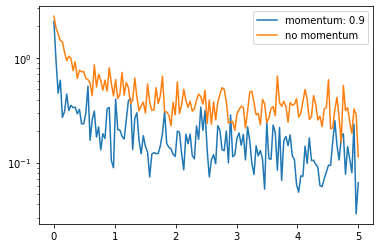

In [12]:
x_axis = np.linspace(0, 5, len(train_losses1), endpoint=True)
plt.semilogy(x_axis, train_losses1, label='momentum: 0.9')
plt.semilogy(x_axis, train_losses2, label='no momentum')
plt.legend(loc='best')

可以看到, 动量法比`sgd`收敛更快, 可以将动量理解为一种惯性作用，所以每次更新的幅度都会比不加动量的情况更多